# Setup

In [175]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np
import cv2

In [249]:
%aimport am_registration.rotation
%aimport am_registration.utils
%aimport am_registration.clustering
%aimport am_registration.visual
%aimport am_registration.image_processing
from am_registration.rotation import *
from am_registration.utils import *
from am_registration.clustering import *
from am_registration.visual import *
from am_registration.image_processing import *

In [250]:
import logging
if not logging.getLogger('am-reg').handlers:
    init_logger()
logger = logging.getLogger('am-reg')

# Load Data

In [179]:
path = Path('data/test_AM_image')

In [180]:
source = cv2.imread(str(path / 'source.tiff'), cv2.IMREAD_GRAYSCALE)
source.shape

(9469, 15781)

In [181]:
mask = cv2.imread(str(path / 'mask.tiff'), cv2.IMREAD_GRAYSCALE)
# mask = mask / 255
mask.shape

(9469, 15781)

In [182]:
acq_grid_shape = (60, 100)

In [183]:
image = mask.copy().astype(np.uint8)

In [184]:
min_max(image)

(0, 255)

# Rotate Mask

In [185]:
target_axis = 1  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

100

In [186]:
best_angle = optimal_mask_rotation(image, target_axis, angle_range=2, angle_step=0.1)
best_angle

2019-08-23 16:00:32,095 - am-reg - INFO - Target axis: 1, best angle: -0.300, best proj 0.480


-0.2999999999999985

In [187]:
image = rotate(image, best_angle)

In [188]:
# plot_image(cut_patch(image))

# Clean Mask and Find Centers

In [189]:
from functools import partial
# cut = partial(cut_patch, y_offset=150, x_offset=14600, patch=1000)

In [190]:
# image = cut(mask).copy()
# plot_image(image)

In [191]:
# image = mask.copy()
# plot_image(erode_dilate(image))

In [192]:
image = erode_dilate(image)
am_centers = find_am_centers(image)

In [193]:
len(am_centers)

5913

In [194]:
am_centers[:5]

array([[ 9242,  1220],
       [ 9240, 13003],
       [ 9241,  6118],
       [ 9242,  3212],
       [ 9241,   301]])

# Cluster Centers

In [195]:
am_centers.shape

(5913, 2)

In [196]:
target_axis = 0  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

60

In [197]:
y_labels = cluster_coords(am_centers[:,target_axis], acq_grid_shape[target_axis], sample_ratio=1)

2019-08-23 16:00:33,880 - am-reg - INFO - Clustering (5913,) array into 60 clusters


In [198]:
y_axis_coords = am_centers[:,target_axis]

In [199]:
# plot_image_label_overlay(cut_patch(image, 0, 0, 1000),
#                          target_axis, y_axis_coords, y_labels, set(y_labels))

In [200]:
target_axis = 1  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

100

In [201]:
x_labels = cluster_coords(am_centers[:,target_axis], acq_grid_shape[target_axis], sample_ratio=1)

2019-08-23 16:00:34,148 - am-reg - INFO - Clustering (5913,) array into 100 clusters


In [202]:
x_axis_coords = am_centers[:,target_axis]

In [203]:
# plot_image_label_overlay(cut_patch(image, 0, 0, 1000),
#                          target_axis, x_axis_coords, x_labels, set(x_labels))

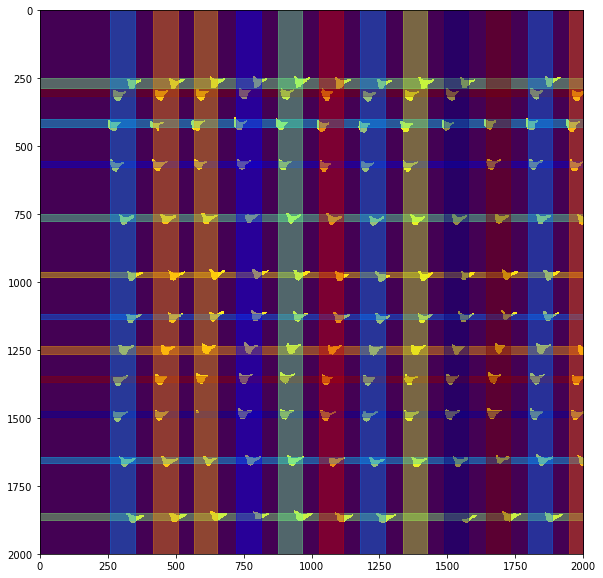

In [204]:
patch = cut_patch(image, 0, 0, 2000)
ax = plot_image(patch)
plot_labels(ax, patch, 0, y_axis_coords, y_labels, set(y_labels))
plot_labels(ax, patch, 1, x_axis_coords, x_labels, set(x_labels))

In [205]:
acq_y_grid = convert_labels_to_grid(y_axis_coords, y_labels, set(y_labels))
# y_grid
acq_x_grid = convert_labels_to_grid(x_axis_coords, x_labels, set(x_labels))
# x_grid
acq_indices = convert_grid_to_indices(acq_y_grid, acq_x_grid, acq_grid_shape[1])
# acq_indices

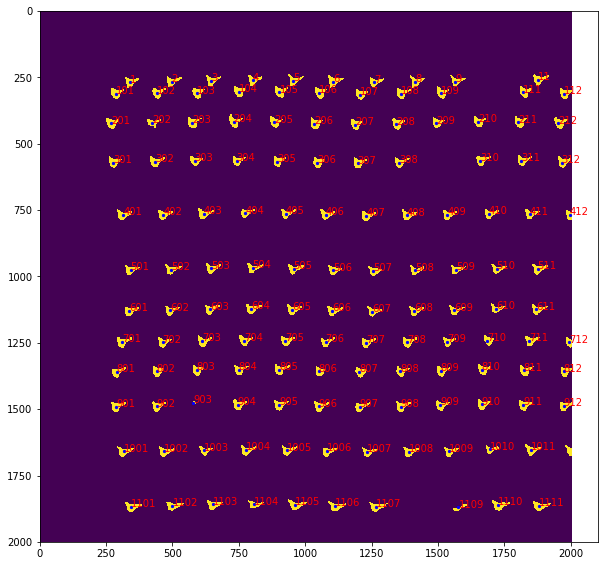

In [206]:
n = patch.shape[0]
mask_ = (am_centers[:,0] < n)&(am_centers[:,1] < n)
plot_am_labels(cut_patch(image, 0, 0, n), am_centers[mask_], acq_indices[mask_])

# Rotate Image and AM Centers Back

In [207]:
best_angle

-0.2999999999999985

In [208]:
image = rotate(image, -best_angle)

In [256]:
# plot_image(cut_patch(image))

In [251]:
am_centers

array([[ 9242,  1220],
       [ 9240, 13003],
       [ 9241,  6118],
       ...,
       [  261, 13638],
       [  259,  4779],
       [  250, 15493]])

In [255]:
am_centers = rotate_am_centers(am_centers, -best_angle, image.shape)
am_centers

array([[ 9277,  1244],
       [ 9213, 13027],
       [ 9250,  6142],
       ...,
       [  231, 13615],
       [  275,  4756],
       [  210, 15469]], dtype=uint16)

# Fill Mask with Acqusition Indices

In [257]:
acq_indices.shape

(5913,)

In [258]:
am_centers

array([[ 9277,  1244],
       [ 9213, 13027],
       [ 9250,  6142],
       ...,
       [  231, 13615],
       [  275,  4756],
       [  210, 15469]], dtype=uint16)

In [259]:
# plot_image(cut_patch(image))

In [260]:
am_n, markers = cv2.connectedComponents(image.copy().astype(np.uint8))
# patch = cut_patch(markers)
# plot_image(cut_patch(markers))

In [261]:
markers_coo = coo_matrix(markers)

marker_acq_index_mapping = np.zeros_like(markers_coo.data)
for (c_row, c_col), acq_idx in zip(am_centers, acq_indices):
    marker = markers[c_row, c_col]
    marker_acq_index_mapping[marker] = acq_idx
    
markers_coo.data = marker_acq_index_mapping[markers_coo.data]
# markers = markers_coo.toarray()

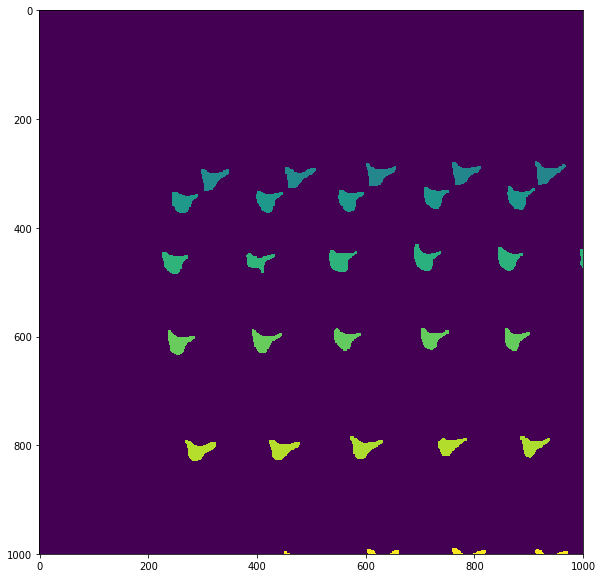

In [262]:
img = markers.copy()
img[img == 0] = -255  # to make the first row with small marker values visible
plot_image(cut_patch(img))

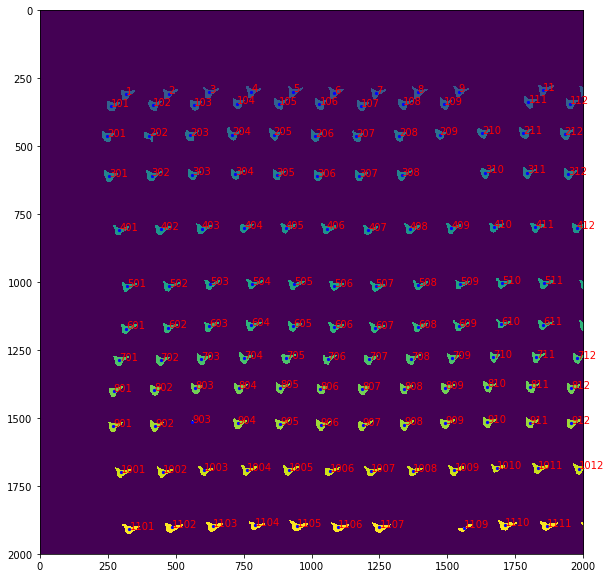

In [263]:
n = patch.shape[0]
mask_ = (am_centers[:,0] < n)&(am_centers[:,1] < n)
plot_am_labels(cut_patch(img, 0, 0, n), am_centers[mask_], acq_indices[mask_])

In [623]:
# plot_image(cut_patch(markers == 0))

# Convert and Save Results

In [264]:
import operator

In [279]:
%%time
am_x_y_coords = []
for acq_idx in range(1, operator.mul(*acq_grid_shape) + 1):
    pixel_inds = (markers_coo.data == acq_idx).nonzero()[0]
    ys = markers_coo.row[pixel_inds]
    xs = markers_coo.col[pixel_inds]
    am_x_y_coords.append([xs, ys])

CPU times: user 21.5 s, sys: 87 ms, total: 21.6 s
Wall time: 21.6 s


In [281]:
np.save('marks_mask.npy', am_x_y_coords)

In [285]:
am_x_y_coords = np.load('marks_mask.npy')

In [291]:
am_x_y_coords[0]

array([array([297, 298, 299, ..., 310, 311, 312], dtype=int32),
       array([293, 293, 293, ..., 331, 331, 331], dtype=int32)],
      dtype=object)

In [292]:
m = np.zeros_like(markers)
for idx, (xs, ys) in enumerate(am_x_y_coords, 1):
    m[ys, xs] = idx

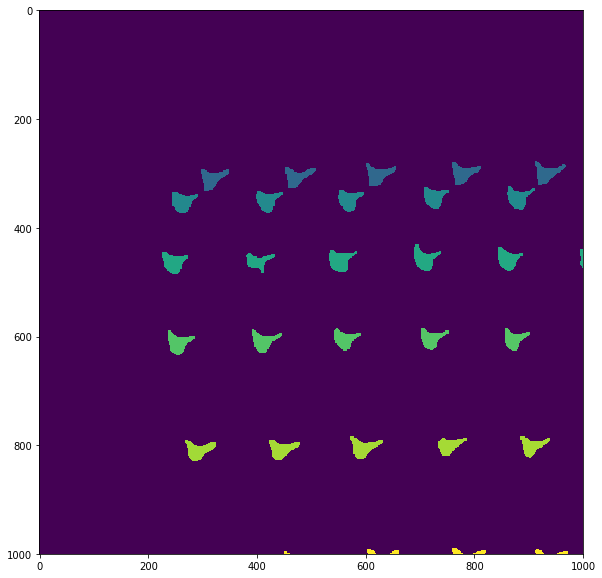

In [293]:
m[m == 0] = -255
plot_image(cut_patch(m))

In [389]:
a = np.load('data/test_AM_image/marksMask.npy')

In [390]:
a.shape

(6000, 2)

In [394]:
xs, ys, = a[0]

In [396]:
xs.shape, ys.shape

((2186,), (2186,))

In [397]:
xs

array([6318.01140169, 6318.01140169, 6318.01140169, ..., 6376.01140169,
       6376.01140169, 6376.01140169])